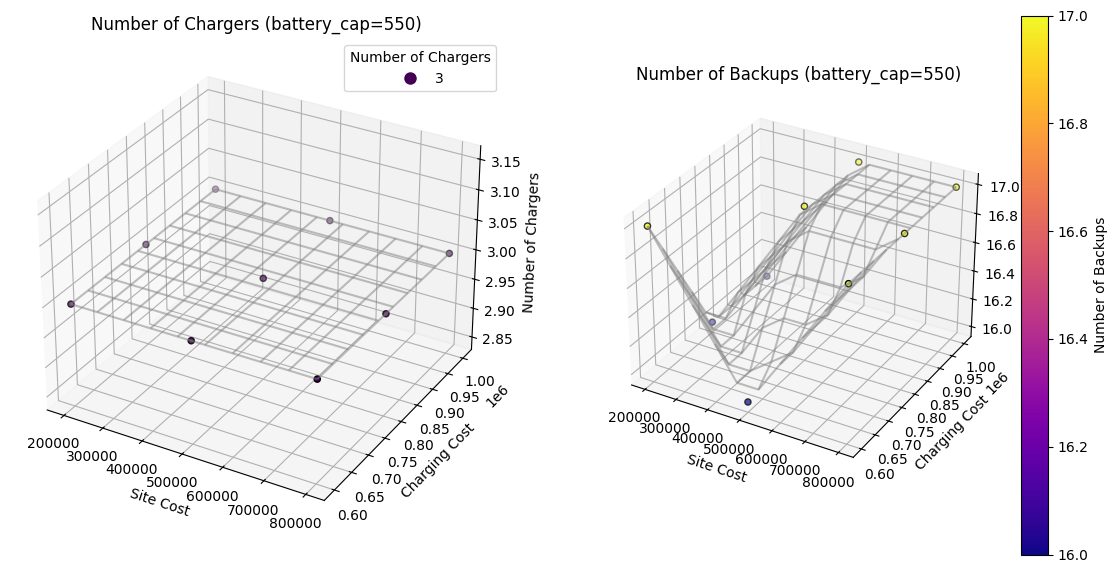

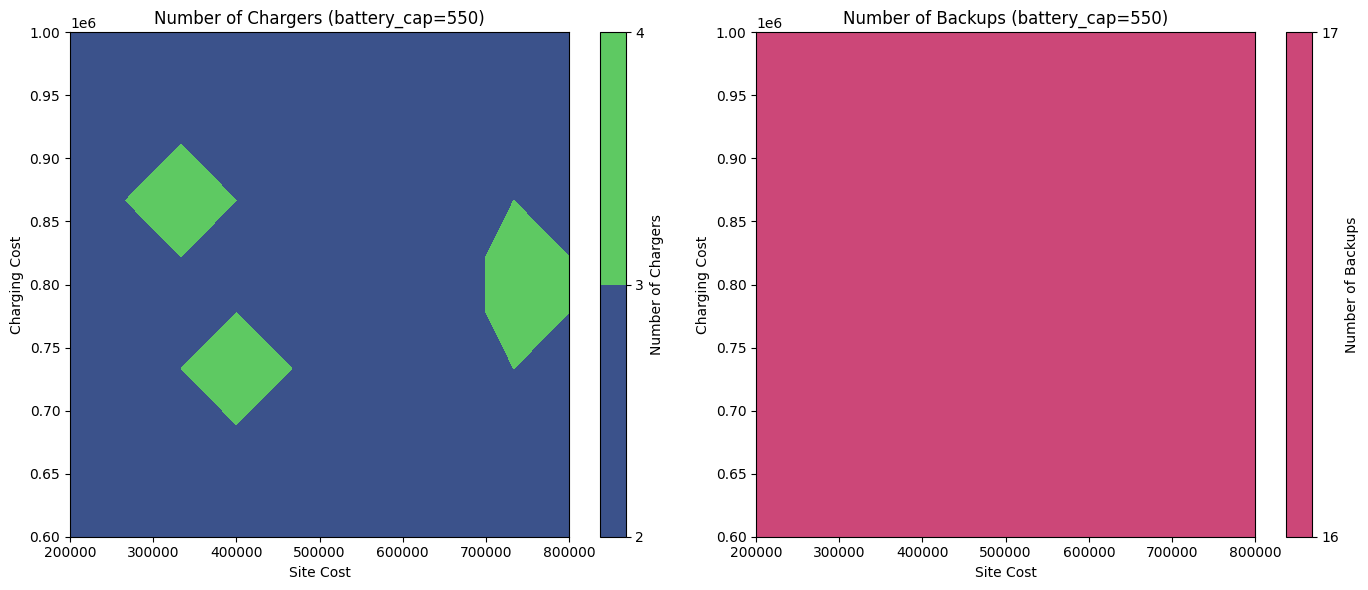

In [4]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata

# Define the directory and file pattern
directory = r"C:\Users\chris\OneDrive - UW\Documents\GitHub\CET593project1\results"
file_pattern = f"{directory}\\result_summary_*_15.csv"  # Update pattern to match files ending with _15.csv

# Use glob to get all files matching the pattern
files = glob.glob(file_pattern)

# Initialize an empty list to store dataframes
dataframes = []

# Loop through the files and read each CSV file
for file in files:
    df = pd.read_csv(file)
    
    # Extract parameters from the filename
    parts = file.split('_')
    n_max = int(parts[2])
    s_cost = int(parts[3])
    c_cost = int(parts[4])
    battery_cap = int(parts[5].split('.')[0])  # Remove file extension

    if (n_max == 4) & (battery_cap == 550):
        # Add parameters as new columns
        df['n_max'] = n_max
        df['s_cost'] = s_cost
        df['c_cost'] = c_cost
        df['battery_cap'] = battery_cap

        dataframes.append(df)

# Concatenate all dataframes into a single dataframe
all_data = pd.concat(dataframes, ignore_index=True)

# Unique battery capacities
battery_caps = all_data['battery_cap'].unique()

# Create 3D plots for each battery capacity
for battery_cap in battery_caps:
    filtered_data = all_data[all_data['battery_cap'] == battery_cap]

    # Create a figure for 3D scatter, wireframe, and contour plots
    fig = plt.figure(figsize=(14, 7))

    # Create a color map with distinct colors for each number of chargers
    num_chargers_unique = sorted(filtered_data['num_chargers'].unique())
    num_chargers_colors = plt.cm.viridis(np.linspace(0, 1, len(num_chargers_unique)))

    # Create a mapping from num_chargers to colors
    num_chargers_color_map = {num: color for num, color in zip(num_chargers_unique, num_chargers_colors)}

    # 3D scatter plot for s_cost vs c_cost vs num_chargers
    ax1 = fig.add_subplot(121, projection='3d')
    for num_chargers in num_chargers_unique:
        subset = filtered_data[filtered_data['num_chargers'] == num_chargers]
        ax1.scatter(subset['s_cost'], subset['c_cost'], subset['num_chargers'], 
                    c=[num_chargers_color_map[num_chargers]], edgecolor='k')

    ax1.set_xlabel('Site Cost')
    ax1.set_ylabel('Charging Cost')
    ax1.set_zlabel('Number of Chargers')
    ax1.set_title(f'Number of Chargers (battery_cap={battery_cap})')
    ax1.grid(True)

    # Add legend for num_chargers
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=num, 
                           markerfacecolor=num_chargers_color_map[num], markersize=10) 
               for num in num_chargers_unique]
    ax1.legend(handles=handles, title='Number of Chargers')

    # Prepare grid for wireframe (num_chargers)
    s_cost_range = np.linspace(filtered_data['s_cost'].min(), filtered_data['s_cost'].max(), 10)
    c_cost_range = np.linspace(filtered_data['c_cost'].min(), filtered_data['c_cost'].max(), 10)
    S, C = np.meshgrid(s_cost_range, c_cost_range)
    
    # Interpolate to get objective values for the wireframe
    Z = griddata((filtered_data['s_cost'], filtered_data['c_cost']), 
                  filtered_data['num_chargers'], (S, C), method='linear')

    # Wireframe plot for s_cost vs c_cost vs num_chargers
    ax1.plot_wireframe(S, C, Z, color='gray', alpha=0.5)

    # 3D scatter plot for s_cost vs c_cost vs n_backups
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(filtered_data['s_cost'], filtered_data['c_cost'], filtered_data['n_backups'], 
                            c=filtered_data['n_backups'], cmap='plasma', edgecolor='k')
    fig.colorbar(scatter2, ax=ax2, label='Number of Backups')
    ax2.set_xlabel('Site Cost')
    ax2.set_ylabel('Charging Cost')
    ax2.set_zlabel('Number of Backups')
    ax2.set_title(f'Number of Backups (battery_cap={battery_cap})')
    ax2.grid(True)

    # Prepare grid for wireframe (n_backups)
    Z_backups = griddata((filtered_data['s_cost'], filtered_data['c_cost']), 
                         filtered_data['n_backups'], (S, C), method='linear')

    # Wireframe plot for s_cost vs c_cost vs n_backups
    ax2.plot_wireframe(S, C, Z_backups, color='gray', alpha=0.5)

    # Create contour plots for num_chargers and n_backups
    fig_contour, ax_contour = plt.subplots(1, 2, figsize=(14, 6))

    # Create integer levels for contours
    num_chargers_levels = np.arange(np.floor(Z.min()), np.ceil(Z.max()) + 1, 1)
    backups_levels = np.arange(np.floor(Z_backups.min()), np.ceil(Z_backups.max()) + 1, 1)

    # Contour plot for num_chargers
    contour1 = ax_contour[0].contourf(S, C, Z, levels=num_chargers_levels, cmap='viridis')
    fig_contour.colorbar(contour1, ax=ax_contour[0], label='Number of Chargers')
    ax_contour[0].set_title(f'Number of Chargers (battery_cap={battery_cap})')
    ax_contour[0].set_xlabel('Site Cost')
    ax_contour[0].set_ylabel('Charging Cost')

    # Contour plot for n_backups
    contour2 = ax_contour[1].contourf(S, C, Z_backups, levels=backups_levels, cmap='plasma')
    fig_contour.colorbar(contour2, ax=ax_contour[1], label='Number of Backups')
    ax_contour[1].set_title(f'Number of Backups (battery_cap={battery_cap})')
    ax_contour[1].set_xlabel('Site Cost')
    ax_contour[1].set_ylabel('Charging Cost')

    plt.tight_layout()
    plt.show()
    plt.pause(0.1)  # Add this line to ensure plots render correctly

    # Turn off interactive mode after showing the plot
    plt.ioff()
